## Import des librairies 

In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

#from auto_ts import auto_timeseries
from pmdarima.arima import auto_arima,ADFTest
from autots import AutoTS

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings


## On va essayer de construire un modèle pour chaque famille produit dans ce notebook 

## Fonctions qui seront utilisées

In [4]:
def r2_ajuste(r2,n,p):

    return  1 - (  ((1 - r2) * (n - 1)) / (n - p - 1)  )

def determine_petit_truc(series):
    min_positive_value = series[series > 0].min()
    val = 0.00001
    return min_positive_value * val

# Fonction pour tester la stationnarité avec le test ADF
def test_stationarity(series):
    result = adfuller(series.dropna())
    return result[1]  # Retourne la p-value

# Fonction pour appliquer la transformation logarithmique
def apply_log(series, p):
    return np.log(series + p)

## reconstruction pour un dataframe 
def deDiff(orig, diff,order,log_order):
    dfout = pd.DataFrame(index=orig.index, columns=orig.columns)
    cols = orig.columns

    for family in cols:
        #affectation des premières valeurs 
        dfout[family].iloc[:order] = orig[family].iloc[:order]
        # recontruction du reste
        for i in range(order, len(orig)):
            dfout[family].iloc[i] = dfout[family].iloc[i-order]  +  diff[family].iloc[i-order]
        dfout[family]
        if log_order == 1:
            dfout = np.exp(dfout)
    return dfout
## reconstruction pour une colonne de dataframe 

def deDiffFamily(orig, diff, order,log_order):
    """
    Fonction poure reconstruire les colonnes de dataframes à différenciation
    orig = la colonne originale
    diff = la colonne des valuers différenciées
    order = l'ordre de différentiation de la colone
    log_order = 1 si on a utilisé un logarithme et 0 sinon
    """
    dfout = pd.Series(index=orig.index, dtype=orig.dtype)
    dfout.iloc[:order] = orig.iloc[:order]
    for i in range(order, len(orig)):
        dfout.iloc[i] = dfout.iloc[i-order] + diff.iloc[i-order]
    if log_order == 1:
        dfout = np.exp(dfout)
    return dfout

## Chargement des données 

In [5]:
dfOrig = pd.read_csv("D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\Processed\\Product families over time.csv")
dfOrig = dfOrig.set_index('Product Family').T

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
D:\WK\ydongue\AppData\Local\Temp\ipykernel_21104\3100426780.py:1: SyntaxWarning: invalid escape sequence '\A'
  dfOrig = pd.read_csv("D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\Processed\\Product families over time.csv")


In [6]:
# Charger les données des séries différenciées à partir d'un fichier CSV
df_differentiated = pd.read_csv('D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\For_Modeling\\series_differenciees.csv')
df_transfo = pd.read_csv('D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\For_Modeling\\transformations_appliquees.csv')
df_transfo.set_index('family', inplace=True)

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
D:\WK\ydongue\AppData\Local\Temp\ipykernel_21104\3303237026.py:2: SyntaxWarning: invalid escape sequence '\A'
  df_differentiated = pd.read_csv('D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\For_Modeling\\series_differenciees.csv')
D:\WK\ydongue\AppData\Local\Temp\ipykernel_21104\3303237026.py:3: SyntaxWarning: invalid escape sequence '\A'
  df_transfo = pd.read_csv('D:\Alternance_2023_UTT\MS EBDE UTT 23 Prof thesis\Sample_Data\For_Modeling\\transformations_appliquees.csv')


## Auto arima pour trouver le meilleur modèle 

In [7]:
warnings.filterwarnings("ignore")

best_models = {}

n = 3
for col in df_differentiated.columns:
    print(f"Processing series: {col}")

    if col == "Unnamed: 0" : 
        continue
    else : 
        train = dfOrig[col].iloc[:-n]
        test = dfOrig[col].iloc[-n:]
        # Appliquer l'auto-ARIMA pour trouver le meilleur modèle
        model = auto_arima(
            train,
            start_p=1,
            start_q=1,
            max_p=5, 
            max_q=5,
            d = None, #int(diff_fam['ordreP'])
           # seasonal=False,  # Modèle non saisonnier
            error_action='warn',
            stepwise=True,  # Méthode plus rapide en recherchant de manière itérative
            trace=True,  # Afficher le processus de sélection du modèle
            test = "adf"
        )
    best_models[col] = model

# Affichage des modèles trouvés
for col, model in best_models.items():
    print(f"\nBest model for {col}:")
    print(model.summary())


Processing series: Unnamed: 0
Processing series: A
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1302.470, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1335.461, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1308.780, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1309.929, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1333.556, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1303.551, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1305.276, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1305.041, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1303.157, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1306.305, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1301.686, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1306.004, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1307.309, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1303.0

## Affichage du meilleur modèle pour chaque famille

In [8]:
# Exemple de données (à remplacer par les données réelles)
data = {
    "Série Temporelle": list(best_models.keys()),
    "Modèle ARIMA": [f"ARIMA{model.order}" for model in best_models.values()],
    "AIC": [model.aic() for model in best_models.values()],
    "BIC": [model.bic() for model in best_models.values()],
}

# Créer un DataFrame
df_summary = pd.DataFrame(data)

# displaying the DataFrame
df_summary.style.set_properties(**{"border": "1.5px solid #ffffff", "color": "red", 'background-color': '#ccffff'}) # 'background-color': '#ffffb3'

,Série Temporelle,Modèle ARIMA,AIC,BIC
0,A,"ARIMA(1, 1, 1)",1301.685680,1307.361141
1,B,"ARIMA(0, 0, 0)",1314.659372,1318.483418
2,C,"ARIMA(1, 1, 1)",1262.396301,1268.071762
3,D,"ARIMA(0, 0, 1)",1341.508711,1347.244780
4,E,"ARIMA(0, 0, 1)",1439.435262,1445.171331
5,F,"ARIMA(2, 1, 1)",1491.762343,1499.329624
6,G,"ARIMA(3, 1, 2)",1201.096218,1214.338960
7,H,"ARIMA(0, 0, 0)",1180.736937,1184.560983
8,I,"ARIMA(0, 0, 0)",969.375275,973.199321
9,J,"ARIMA(0, 1, 1)",1337.781448,1341.565089


## Calcul des métriques pour le baseline model

#### SMAPE : Symetric Mean Absolute Percentage Error
#### Adjusted SMAPE : Adjusted Symmetric Mean Absolute Percentage Error
#### MAPE : Mean Absolute Percentage Error
#### MAAPE : Mean Arctangent Absolute Percentage Error

In [9]:
# Fonction pour calculer SMAPE
def smape(y_true, y_pred):
    smape_val = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return smape_val

# Fonction pour calculer l'Adjusted SMAPE (ASMAPE)
def adjusted_smape(y_true, y_pred):
    adjsmape = 1/y_true.size  * np.sum( np.abs(y_pred - y_true) / ( np.abs(y_true) + np.abs(y_pred) )*100 )
    oldadjsmape = 100 * np.mean(np.abs(y_pred - y_true) / (0.5 * (np.abs(y_true) + np.abs(y_pred))))
    return adjsmape
# Fonction pour calculer le MAAPE
def maape(actual, forecast):
    maape = np.mean(np.arctan(np.abs((actual - forecast) / actual))) * (180/np.pi)
    return maape


def Calcmape(y_true, y_pred):
    errors = []
    # Boucle sur chaque paire de valeurs réelles et prédites
    for actual, predicted in zip(y_true, y_pred):
        if actual == 0:
            # Ignorer les cas où la valeur réelle est zéro
            continue
        else:
            # Calculer l'erreur absolue en pourcentage et l'ajouter à la liste
            errors.append(np.abs((actual - predicted) / actual))

    # Calculer le MAPE en pourcentage
    if errors:
        res = np.mean(errors) * 100
    else:
        res = None  # Ou 0, selon ce qui est pertinent dans votre cas

    return res

# Créer un dictionnaire pour stocker les métriques
metricsErrors = {}
n = 3
# Parcourir chaque modèle ajusté
for col, model in best_models.items():
    
    # Diviser les données
    train = dfOrig[col].iloc[:-n]
    test = dfOrig[col].iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test
    predictions = model.predict(n_periods=n)

    # Calculer les métriques
    me = (predictions - test.values).mean()
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mape = Calcmape(test.values, predictions)
    maape_value = maape(test.values, predictions)
    smape_value = smape(test.values, predictions)
    asmape_value = adjusted_smape(test.values, predictions)

    if train is not None:
        naive_forecast = np.roll(train, shift=1)[1:]
        naive_mae = np.mean(np.abs(train[1:] - naive_forecast))
        mase = mae / naive_mae
    else:
        mase = None
    # Enregistrer les métriques
    metricsErrors[col] = {
        "ME":me,
        "RMSE":rmse,
        "MAE":mae, 
        "MASE":mase,
        "MAAPE": maape_value,
        "MAPE": mape,
        "ASMAPE": asmape_value
    }

# Afficher les métriques pour chaque série
for col, metricsErrors in metricsErrors.items():
    print(f"\nMetrics for {col}:")
    
    print(f"ME: {metricsErrors['ME']}")
    print(f"RMSE: {metricsErrors['RMSE']}")
    print(f"MAE: {metricsErrors['MAE']}")
    print(f"MASE: {metricsErrors['MASE']}")
    
    
    print(f"MAAPE: {metricsErrors['MAAPE']}°")
    print(f"MAPE: {metricsErrors['MAPE']}%")
    print(f"ASMAPE: {metricsErrors['ASMAPE']}%")


Metrics for A:
ME: 38865.609644612414
RMSE: 68809.07072855945
MAE: 50356.57959193174
MASE: 0.3252994436301709
MAAPE: 6.213651396647356°
MAPE: 11.052555756992895%
ASMAPE: 4.994080320315471%

Metrics for B:
ME: -80997.44
RMSE: 163746.92446135776
MAE: 134463.14666666667
MASE: 1.034864113265577
MAAPE: 23.618357818656392°
MAPE: 44.73790810744027%
ASMAPE: 24.05145406492257%

Metrics for C:
ME: -40787.12203265143
RMSE: 87950.68564210324
MAE: 59723.21626785848
MASE: 0.5431801910173483
MAAPE: 15.06581207597896°
MAPE: 27.842618717436345%
ASMAPE: 16.757818182587496%

Metrics for D:
ME: 203457.19040596773
RMSE: 212449.33975794143
MAE: 203457.19040596773
MASE: 1.0218844319737204
MAAPE: 71.46119766470437°
MAPE: 1466.9474820304279%
ASMAPE: 70.73634100501144%

Metrics for E:
ME: -78086.36959945991
RMSE: 437397.5468989378
MAE: 351375.58751817845
MASE: 0.6726599385994196
MAAPE: 40.91388463408192°
MAPE: 31.665004722400848%
ASMAPE: 48.32790196999105%

Metrics for F:
ME: -322591.77870630316
RMSE: 780509.9

## Analyse des résidus des modèles

In [10]:
metrics = {}
n = 3
# Parcourir chaque modèle ajusté
for col, model in best_models.items():

    # Diviser les données
    train = dfOrig[col].iloc[:-n]
    test = dfOrig[col].iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test
    predictions = model.predict(n_periods=n)
    
    # Calculer les résidus
    residuals = test.values - predictions
    
    # Test de normalité des résidus (Shapiro-Wilk)
    shapiro_test = shapiro(residuals)
    
    # Test d'autocorrélation des lags et de blancheur des résidus (Ljung-Box)
    ljungbox_test = acorr_ljungbox(residuals, lags=[2], return_df=True)
    
    # Stocker les résultats dans le dictionnaire
    metrics[col] = {
        'Residuals': residuals,
        'Shapiro-Wilk p-value': shapiro_test.pvalue,
        'Ljung-Box p-value': ljungbox_test['lb_pvalue'].values[0]
    }
    
    # Afficher les résidus et leur autocorrélogramme
    print(f"Résultats pour {col}:")
    #print(f"Résidus:\n{residuals}")
    print(f"Test de Shapiro-Wilk p-value: {shapiro_test.pvalue}")
    print(f"Test de Ljung-Box p-value: {ljungbox_test['lb_pvalue'].values[0]}\n")
    
    # Tracer l'Autocorrelation Function (ACF) des résidus
    # plot_acf(residuals)
    # plt.title(f'Autocorrelation des résidus pour {col}')
    # plt.show()

Résultats pour A:
Test de Shapiro-Wilk p-value: 0.4772774434761654
Test de Ljung-Box p-value: 0.5348828064772931

Résultats pour B:
Test de Shapiro-Wilk p-value: 0.7740014986297634
Test de Ljung-Box p-value: 0.4842667756185557

Résultats pour C:
Test de Shapiro-Wilk p-value: 0.12043182594723412
Test de Ljung-Box p-value: 0.15641796343345185

Résultats pour D:
Test de Shapiro-Wilk p-value: 0.015959699186880894
Test de Ljung-Box p-value: 0.1534085158107957

Résultats pour E:
Test de Shapiro-Wilk p-value: 0.7768246380195625
Test de Ljung-Box p-value: 0.4832908742422243

Résultats pour F:
Test de Shapiro-Wilk p-value: 0.6495177285925895
Test de Ljung-Box p-value: 0.25143704439331926

Résultats pour G:
Test de Shapiro-Wilk p-value: 0.1288346025999354
Test de Ljung-Box p-value: 0.1568625922126249

Résultats pour H:
Test de Shapiro-Wilk p-value: 0.026858289475076402
Test de Ljung-Box p-value: 0.37968025229438374

Résultats pour I:
Test de Shapiro-Wilk p-value: 0.06616748089265179
Test de Ljun

## Enregistrement de tout ca 

In [17]:
import pandas as pd

# Initialiser une liste pour stocker les résultats
results = []

# Parcourir chaque modèle ajusté
for col, model in best_models.items():

    # Diviser les données
    train = dfOrig[col].iloc[:-n]
    test = dfOrig[col].iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test
    predictions = model.predict(n_periods=n)

    # Calculer les résidus
    residuals = test.values - predictions
    
    # Test de normalité des résidus (Shapiro-Wilk)
    shapiro_test = shapiro(residuals)
    
    # Test d'autocorrélation des lags et de blancheur des résidus (Ljung-Box)
    ljungbox_test = acorr_ljungbox(residuals, lags=[2], return_df=True)
    
    # Calculer les métriques d'erreur
    me = (predictions - test.values).mean()
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mape = Calcmape(test.values, predictions)
    maape_value = maape(test.values, predictions)
    smape_value = smape(test.values, predictions)
    asmape_value = adjusted_smape(test.values, predictions)
#    "Modèle ARIMA": [f"ARIMA{model.order}" for model in best_models.values()],

    if train is not None:
        naive_forecast = np.roll(train, shift=1)[1:]
        naive_mae = np.mean(np.abs(train[1:] - naive_forecast))
        mase = mae / naive_mae
    else:
        mase = None

    # Stocker les résultats dans une ligne de dataframe
    results.append({
        'Product Family': col,
        'Model': f"ARIMA {model.order}",
        'Shapiro-Wilk p-value': shapiro_test.pvalue,
        'Ljung-Box p-value': ljungbox_test['lb_pvalue'].values[0],
        
        'MAAPE': f"{round(maape_value,2)}°",
        'MAPE': f"{round(mape,2)}%",
        'ME': me,
        'RMSE': rmse,
        'MAE': mae,
        'MASE': mase,

        'SMAPE': f"{smape_value}%",
        'ASMAPE': f"{asmape_value}%",

    })

# Convertir la liste de résultats en un DataFrame
results_df = pd.DataFrame(results)

In [18]:
results_df.style.set_properties(**{"border": "1.5px solid #ffffff"})#, "color": "green"})#, 'background-color': '#ccffff'})

,Product Family,Model,Shapiro-Wilk p-value,Ljung-Box p-value,MAAPE,MAPE,ME,RMSE,MAE,MASE,SMAPE,ASMAPE
0,A,"ARIMA (1, 1, 1)",0.477277,0.534883,6.21°,11.05%,38865.609645,68809.070729,50356.579592,0.325299,9.988160640630943%,4.994080320315471%
1,B,"ARIMA (0, 0, 0)",0.774001,0.484267,23.62°,44.74%,-80997.440000,163746.924461,134463.146667,1.034864,48.10290812984515%,24.05145406492257%
2,C,"ARIMA (1, 1, 1)",0.120432,0.156418,15.07°,27.84%,-40787.122033,87950.685642,59723.216268,0.543180,33.51563636517499%,16.757818182587496%
3,D,"ARIMA (0, 0, 1)",0.015960,0.153409,71.46°,1466.95%,203457.190406,212449.339758,203457.190406,1.021884,141.47268201002288%,70.73634100501144%
4,E,"ARIMA (0, 0, 1)",0.776825,0.483291,40.91°,31.67%,-78086.369599,437397.546899,351375.587518,0.672660,96.6558039399821%,48.32790196999105%
5,F,"ARIMA (2, 1, 1)",0.649518,0.251437,43.58°,325.18%,-322591.778706,780509.928630,739230.542669,0.716938,92.99357170389987%,46.49678585194994%
6,G,"ARIMA (3, 1, 2)",0.128835,0.156863,14.96°,27.44%,-11933.473173,31238.417829,23178.417590,0.442409,32.30549595546935%,16.152747977734673%
7,H,"ARIMA (0, 0, 0)",0.026858,0.379680,22.29°,41.86%,-47338.951333,57760.284922,47338.951333,1.401571,55.575296906386974%,27.787648453193487%
8,I,"ARIMA (0, 0, 0)",0.066167,0.420746,42.25°,205.95%,-15975.164000,29102.866574,17596.278667,5.215119,110.64245677777113%,55.32122838888556%
9,J,"ARIMA (0, 1, 1)",0.946072,0.367698,41.21°,292.35%,127144.480637,185159.660688,154033.271323,0.922862,74.22525763459342%,37.11262881729671%


## Plot des prévisions

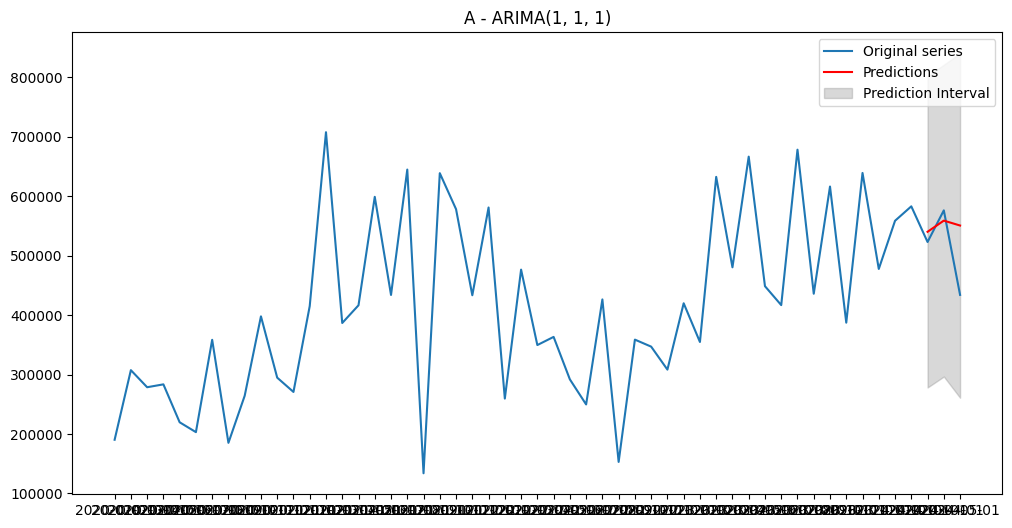

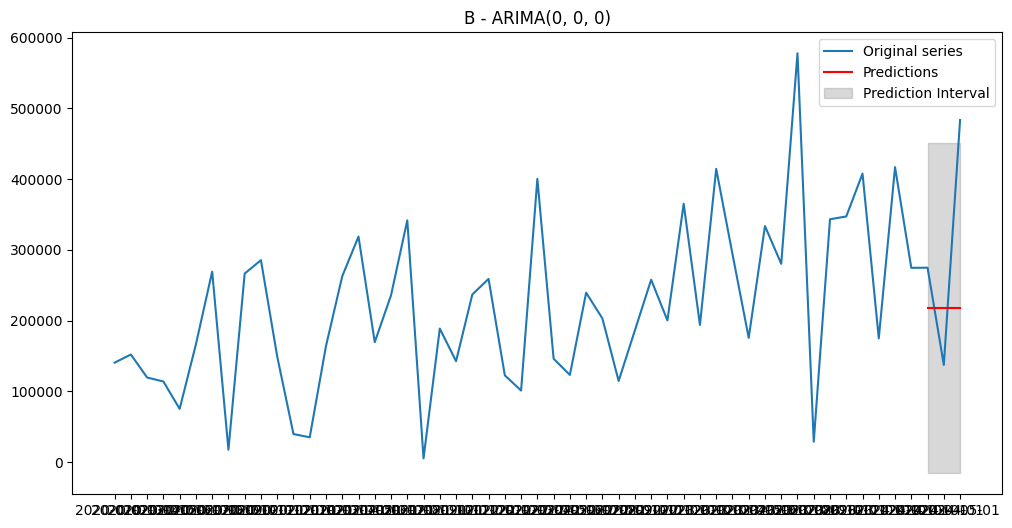

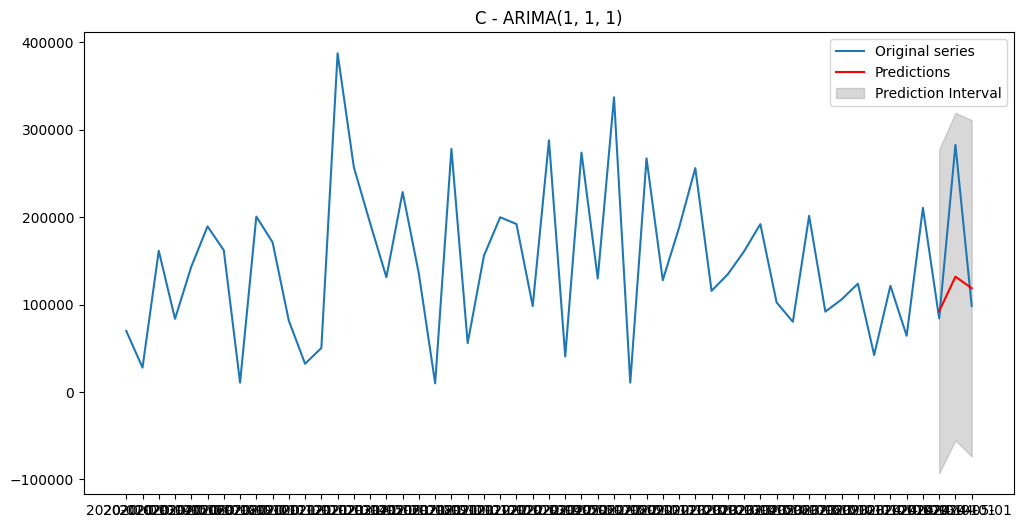

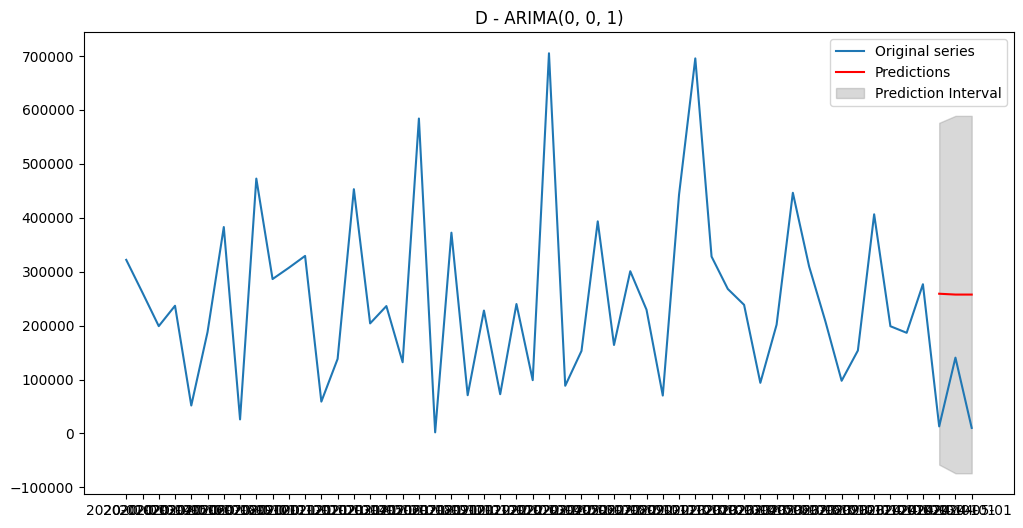

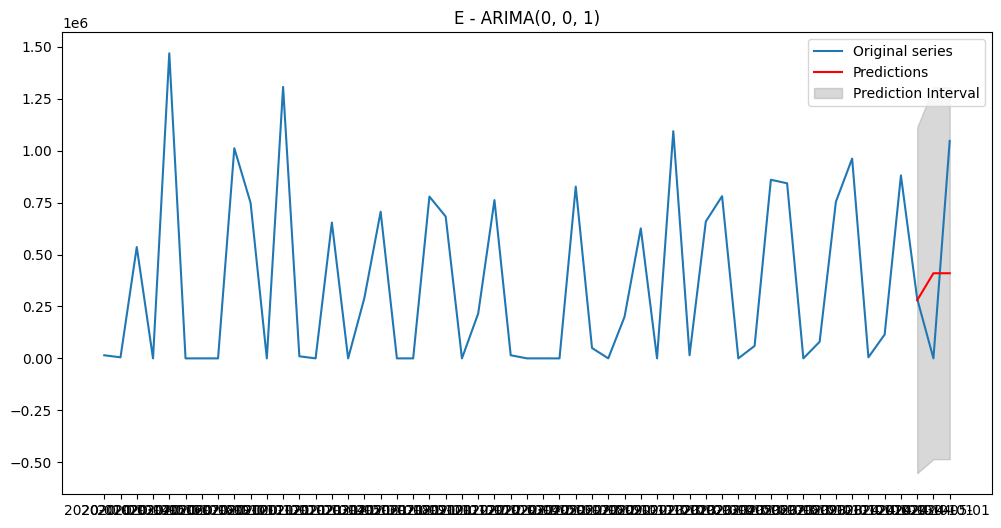

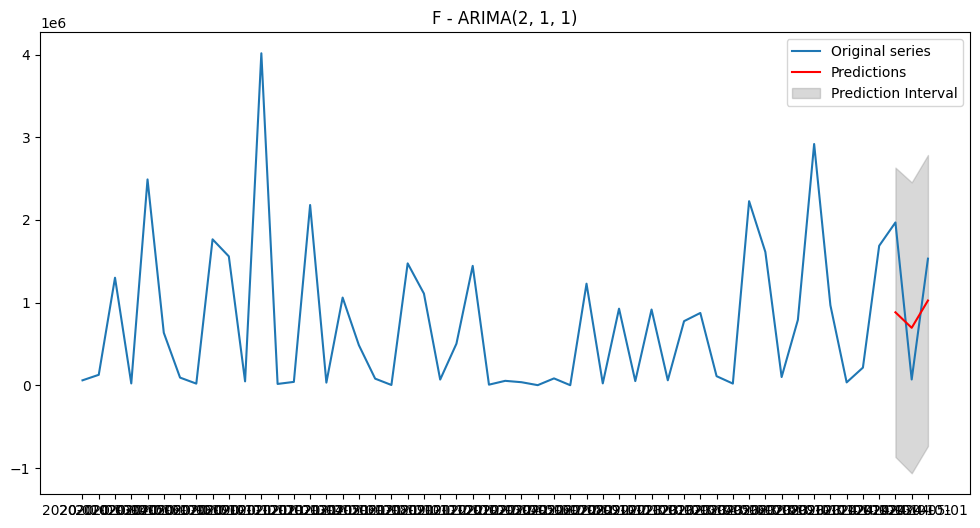

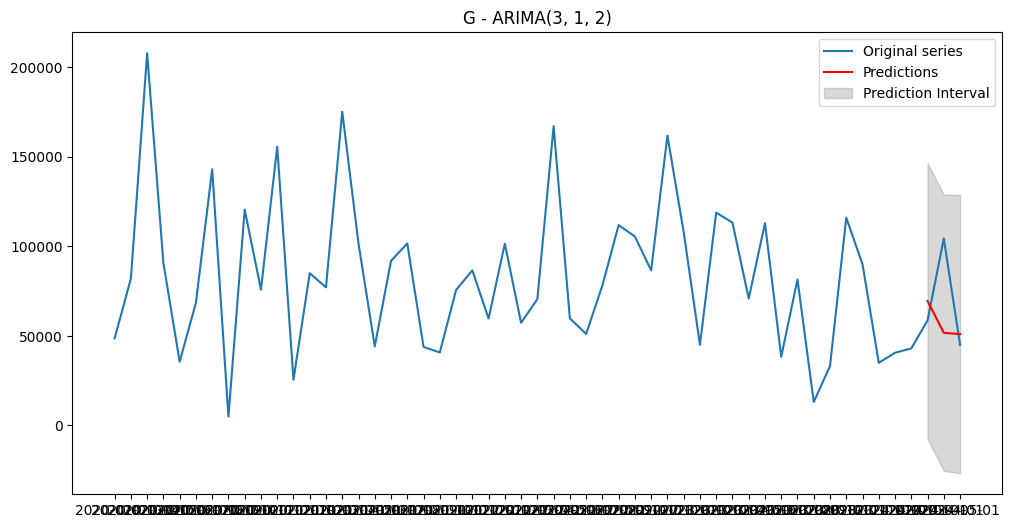

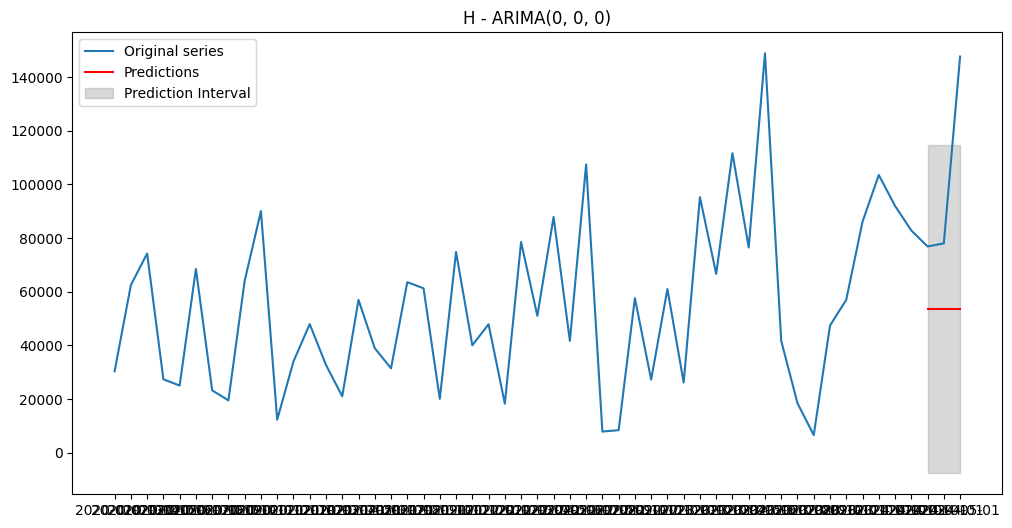

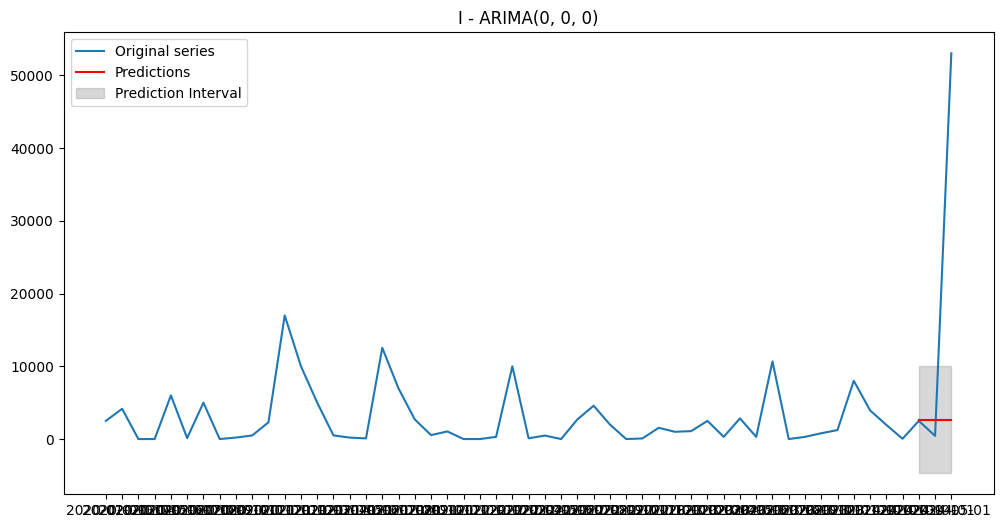

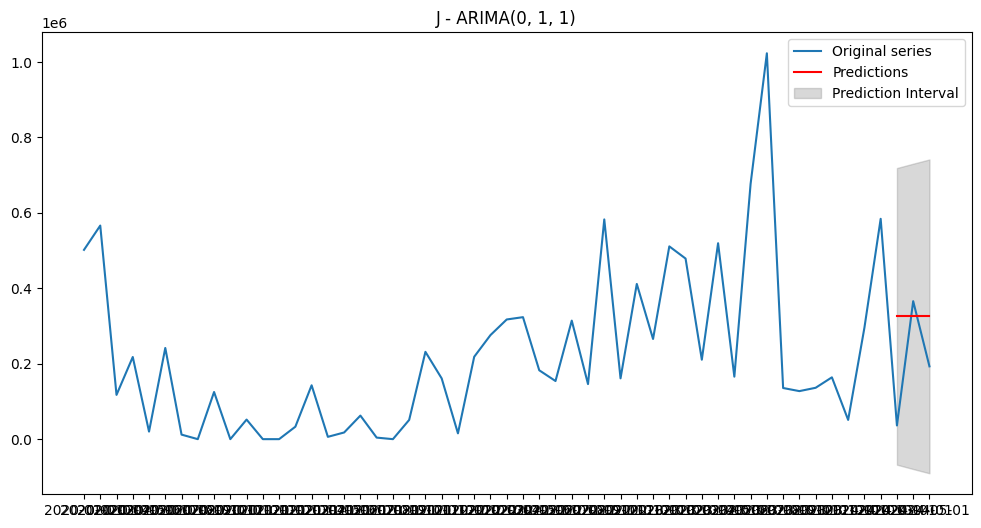

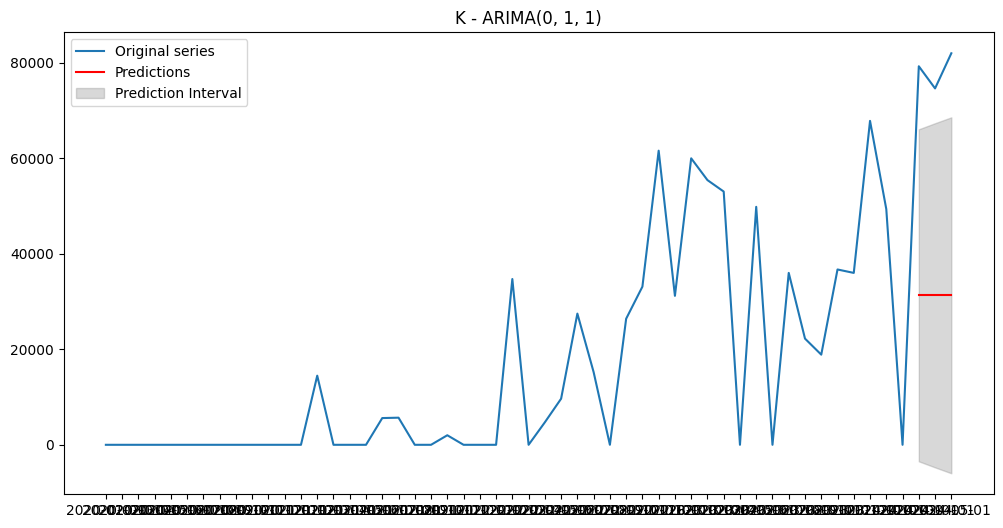

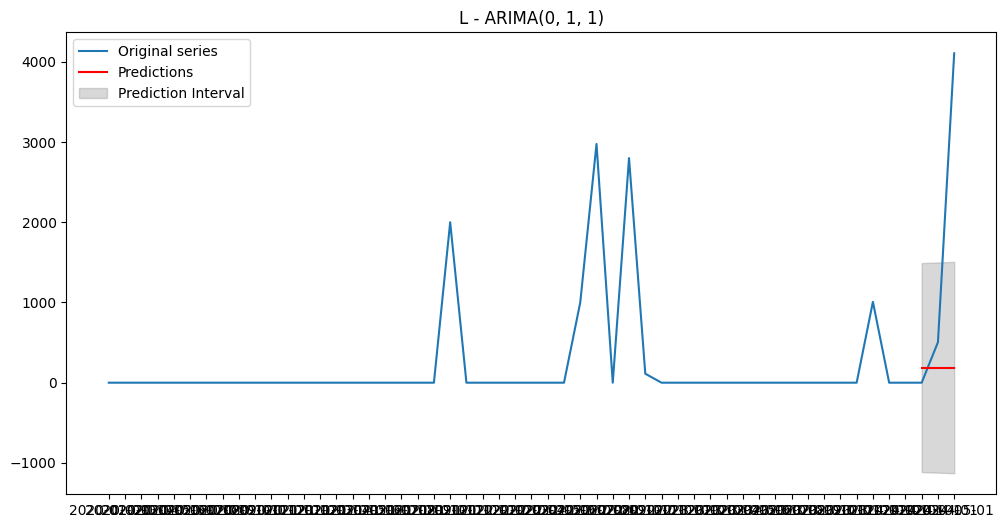

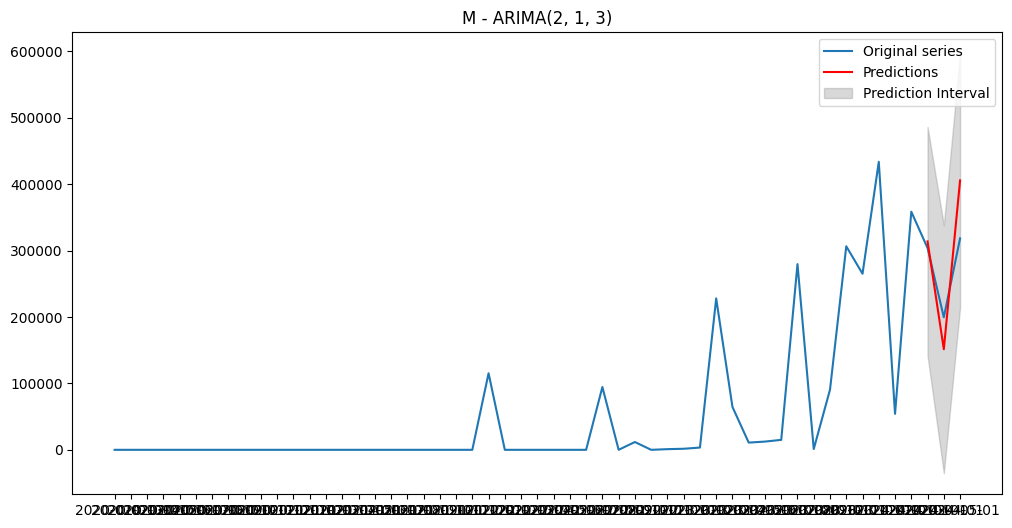

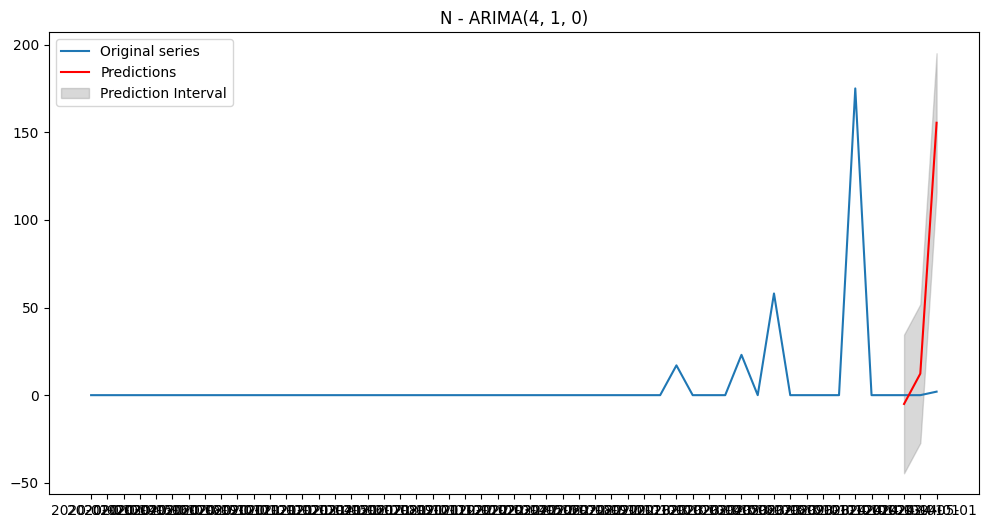

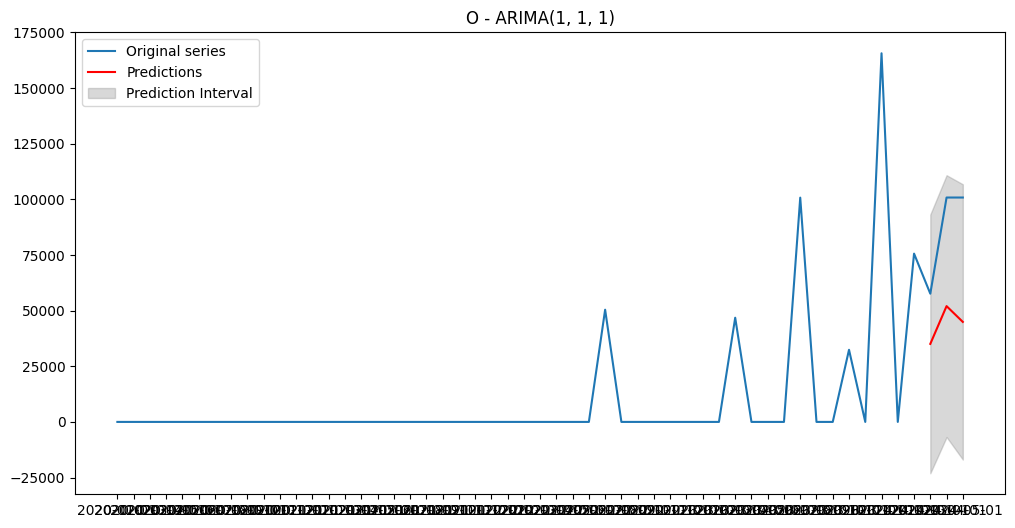

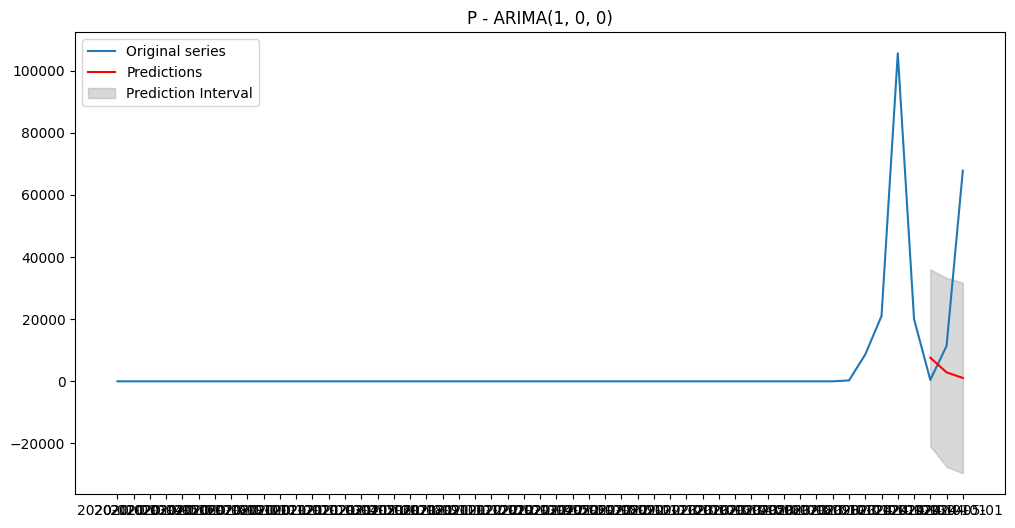

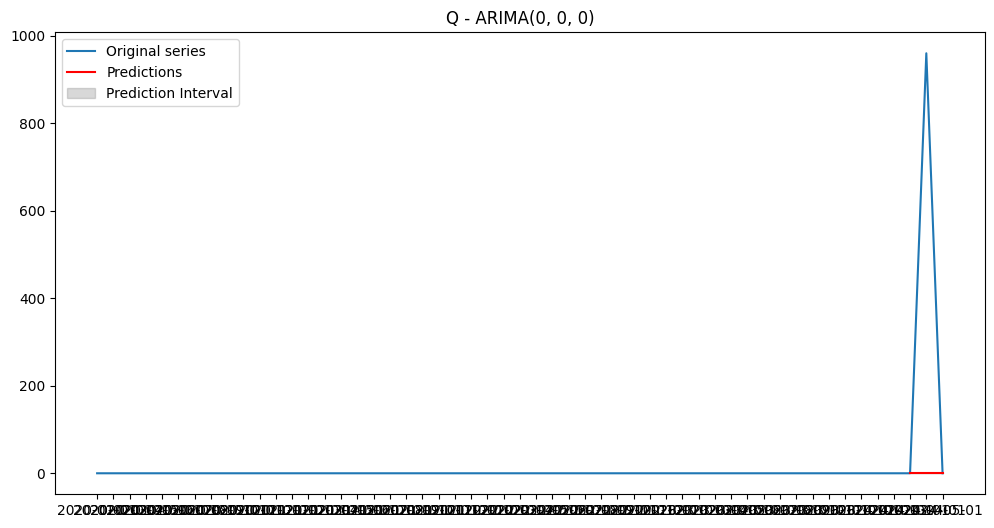

In [13]:
# Parcourir chaque modèle ajusté
for col, model in best_models.items():

    # Diviser les données
    train = dfOrig[col].iloc[:-n]
    test = dfOrig[col].iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test avec intervalle de confiance
    predictions, conf_int = model.predict(n_periods=n, return_conf_int=True)
    
    # Créer une figure pour chaque série
    plt.figure(figsize=(12, 6))
    
    # Tracer la série originale
    plt.plot(dfOrig.index, dfOrig[col], label='Original series')
    
    # Tracer les prévisions
    prediction_index = dfOrig.index[-n:]
    plt.plot(prediction_index, predictions, label='Predictions', color='red')
    
    # Tracer l'intervalle de prédiction
    plt.fill_between(prediction_index, 
                     conf_int[:, 0],  # Limite inférieure de l'intervalle
                     conf_int[:, 1],  # Limite supérieure de l'intervalle
                     color='gray', alpha=0.3, label='Prediction Interval')
    
    plt.title(f'{col} - ARIMA{model.order}')
    # Ajouter une légende
    plt.legend()
    
    # Afficher le graphique
    plt.show()


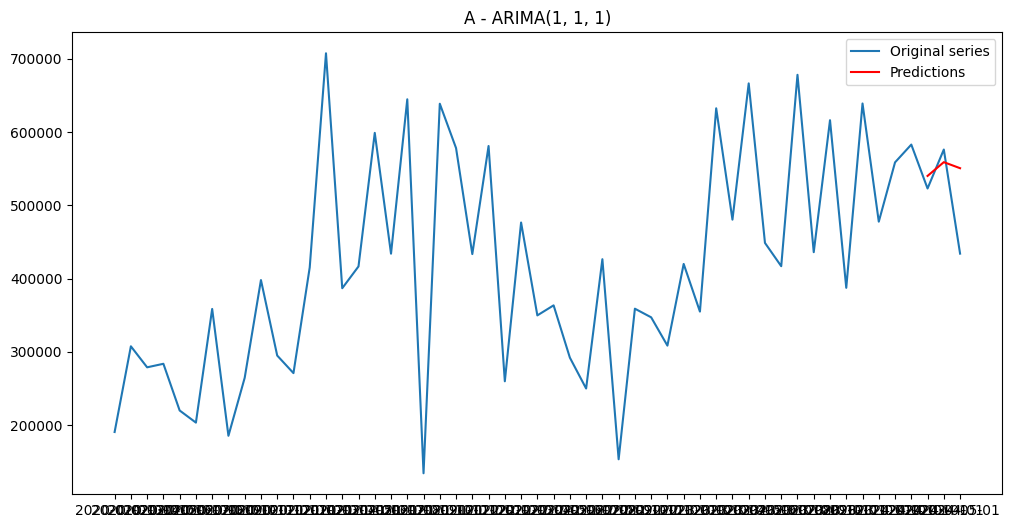

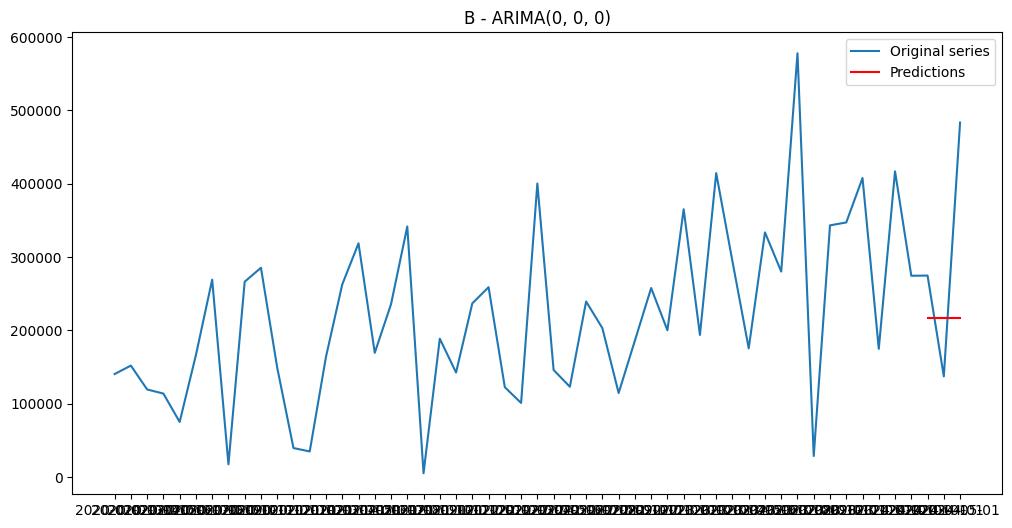

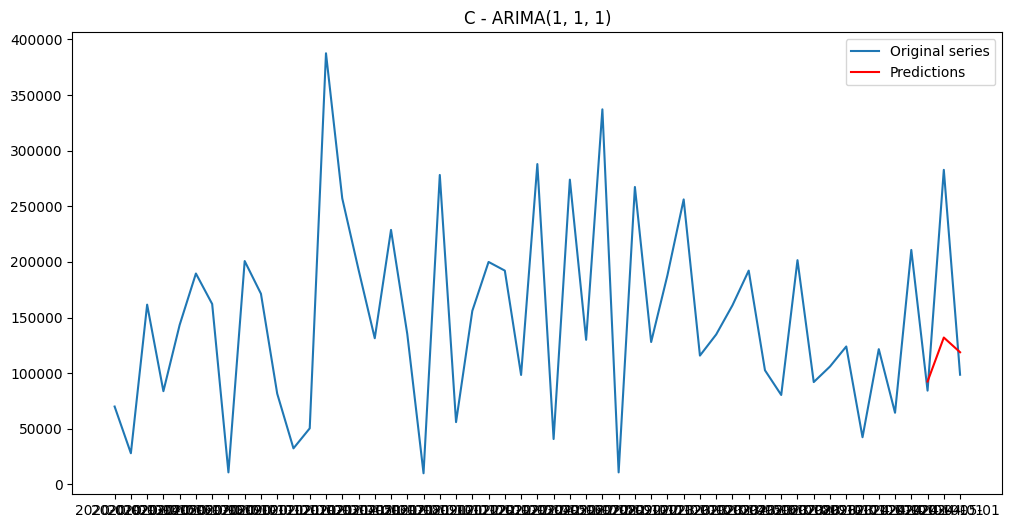

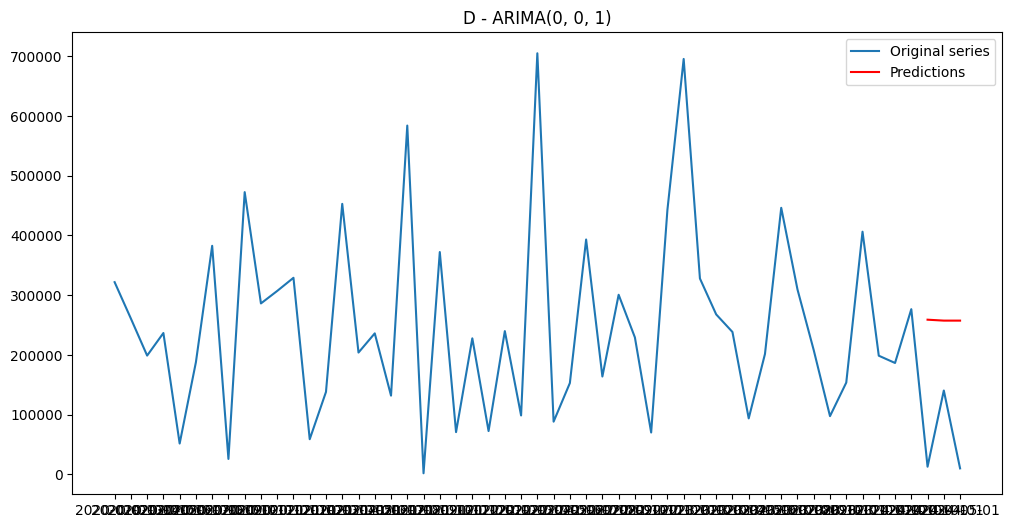

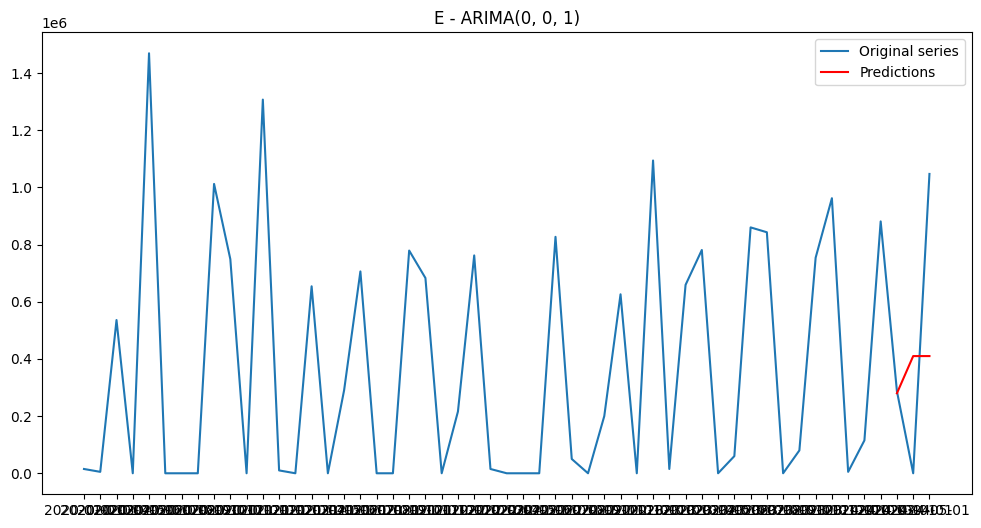

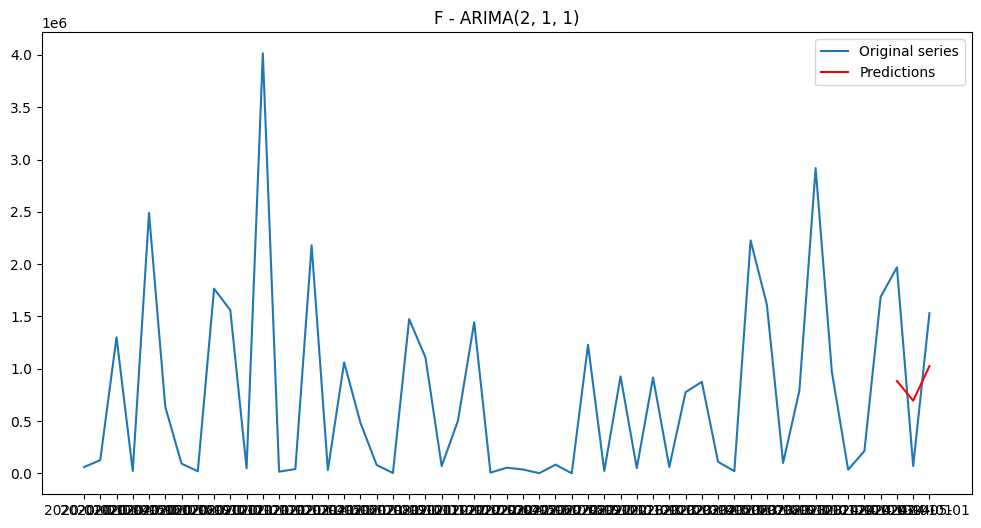

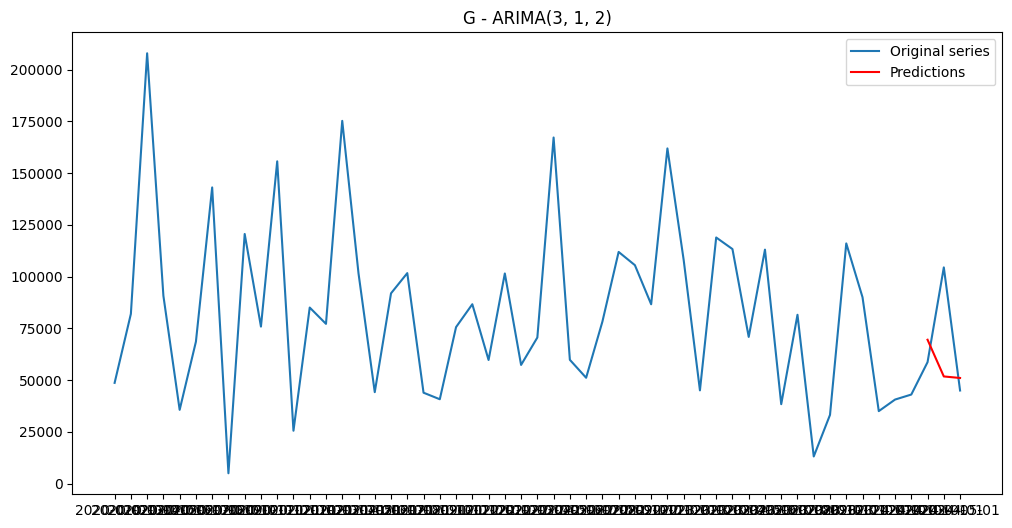

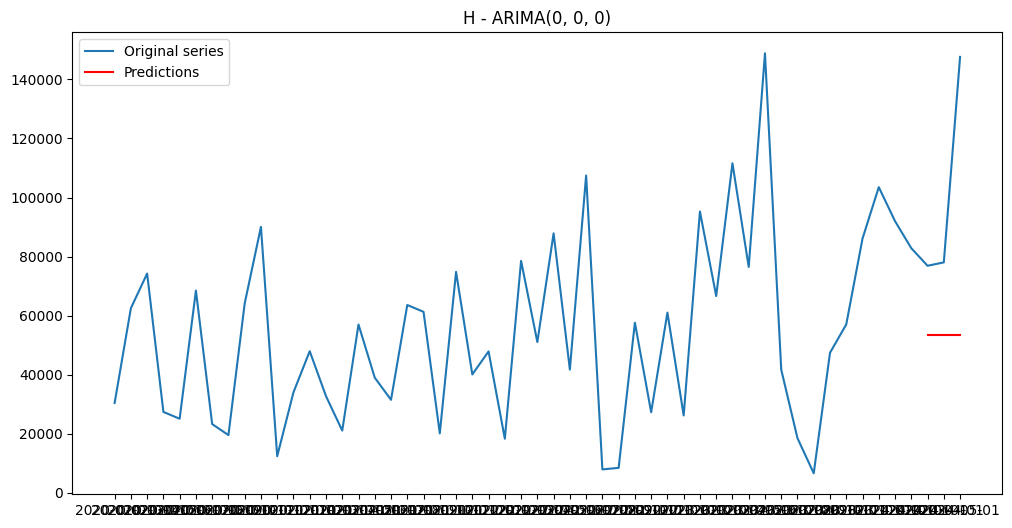

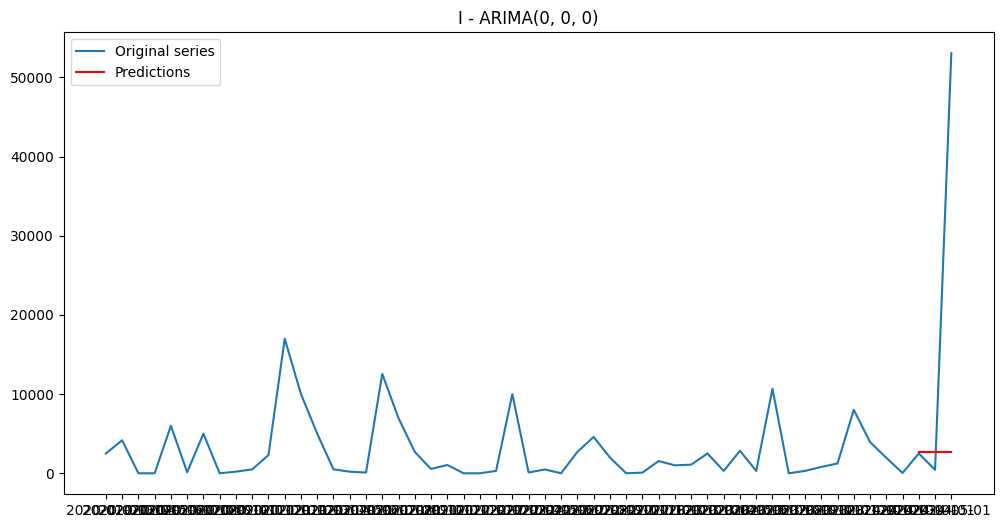

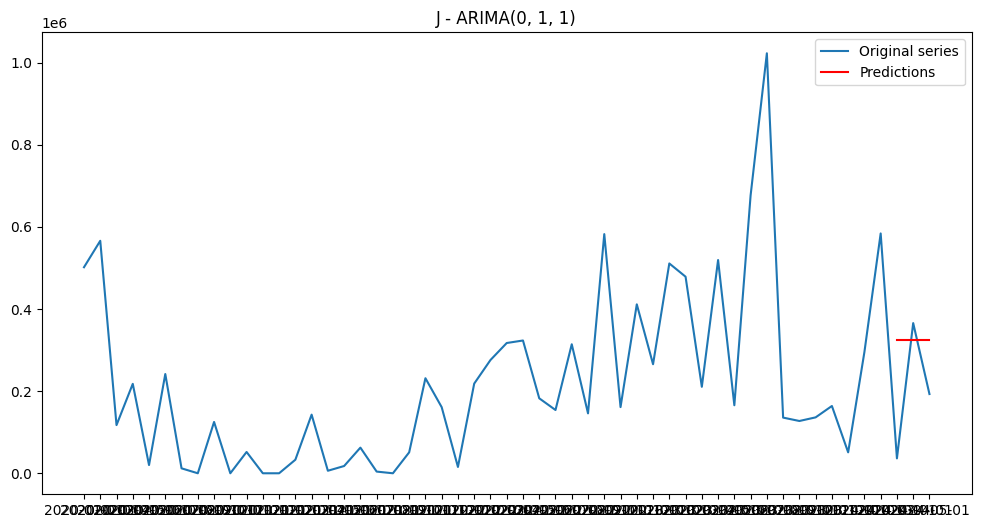

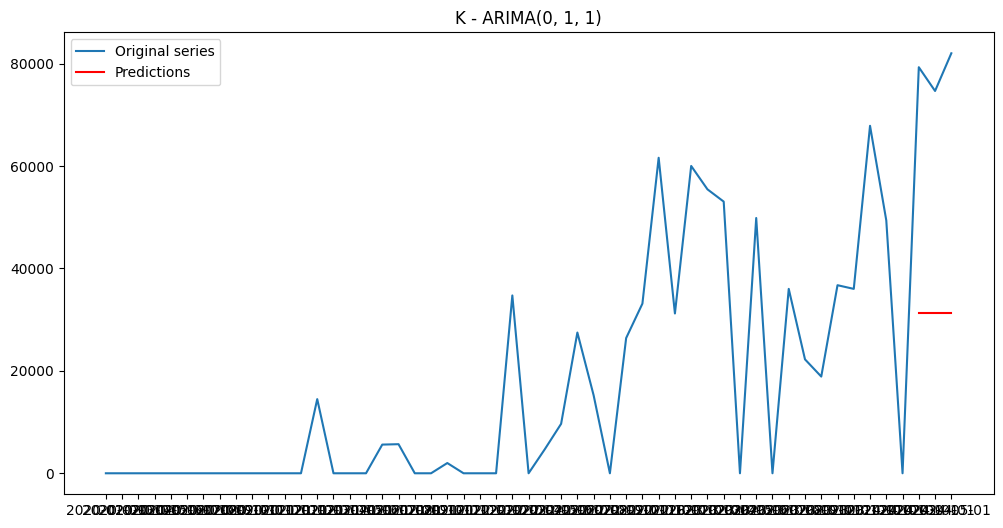

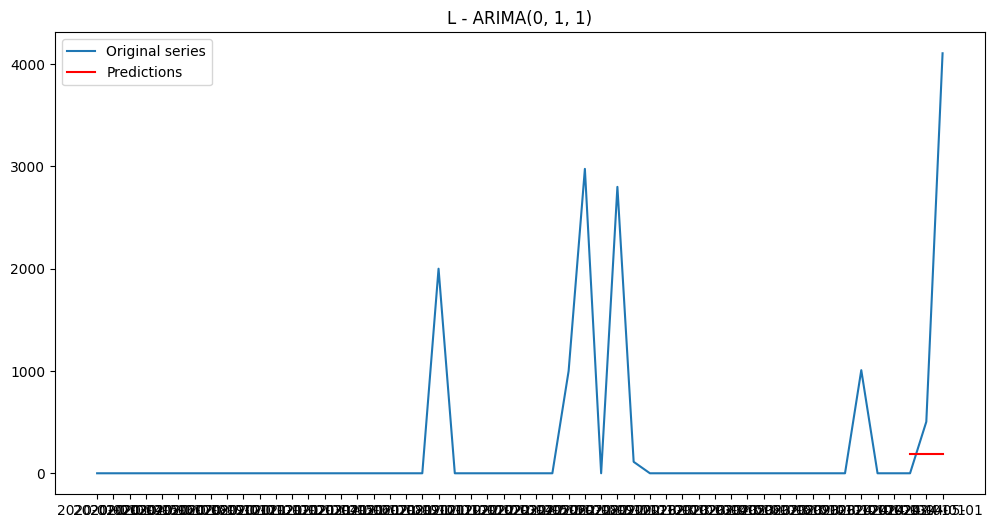

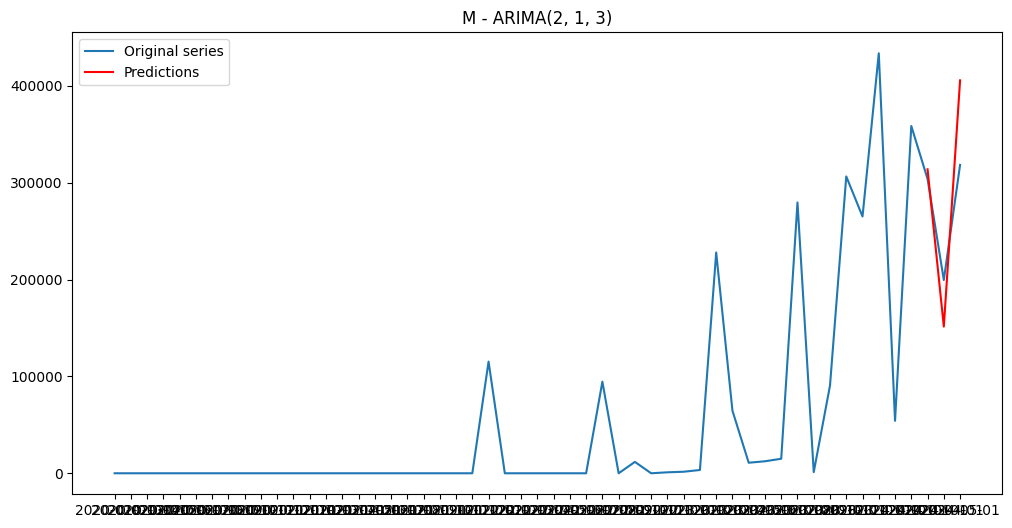

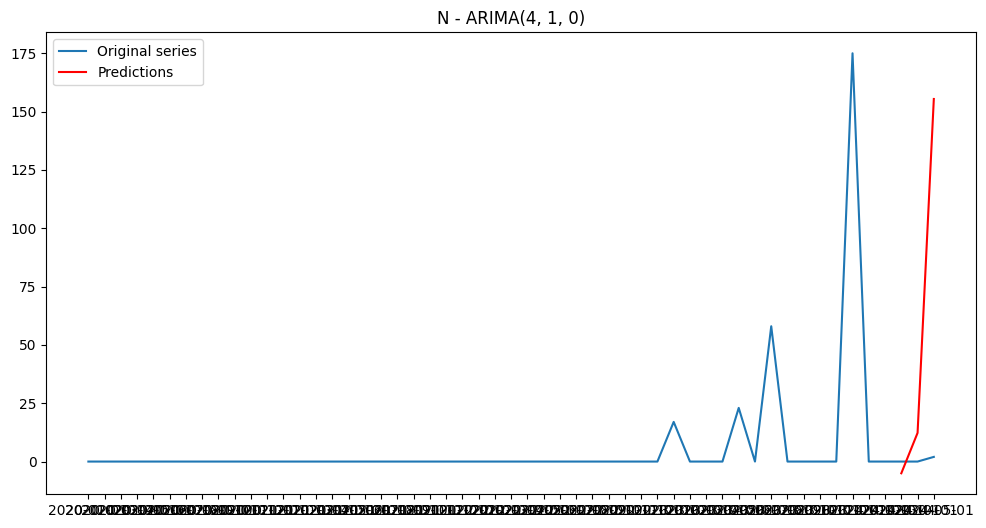

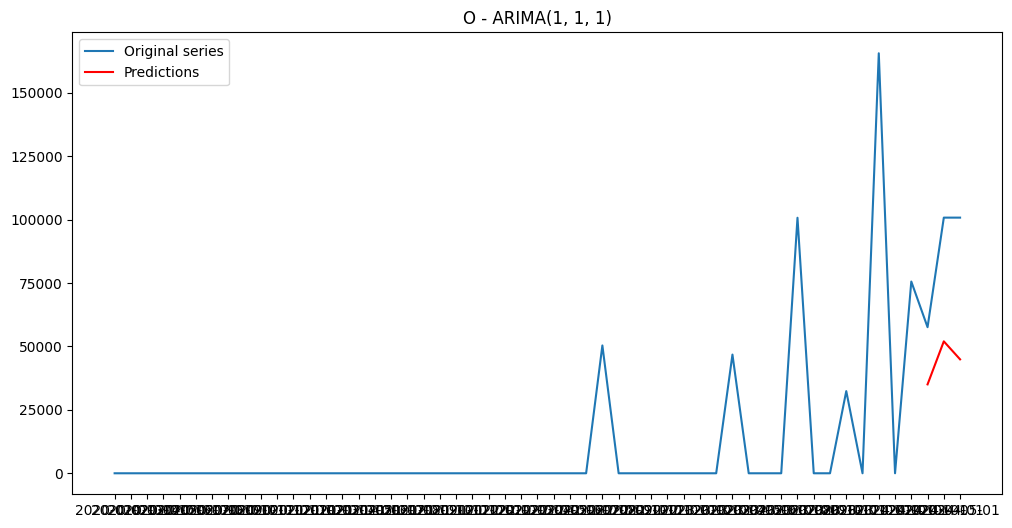

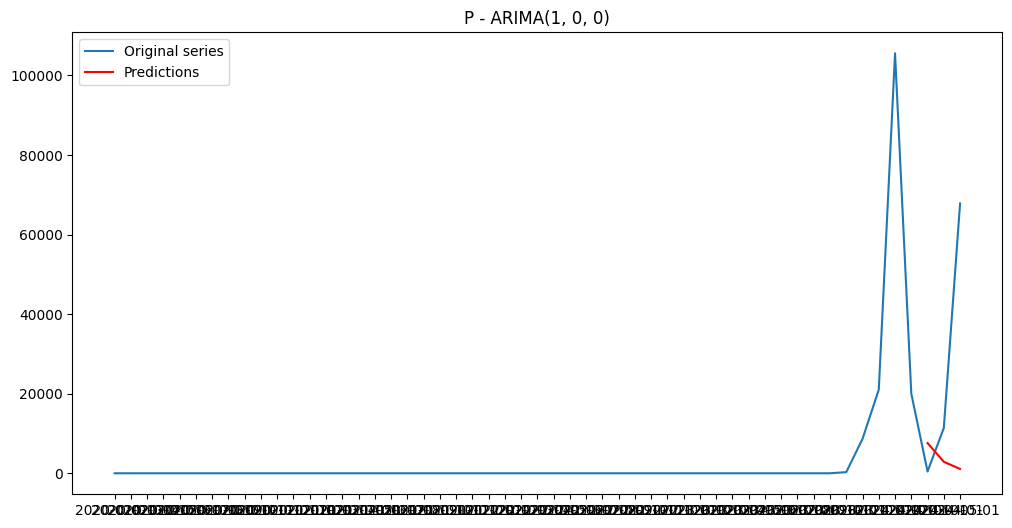

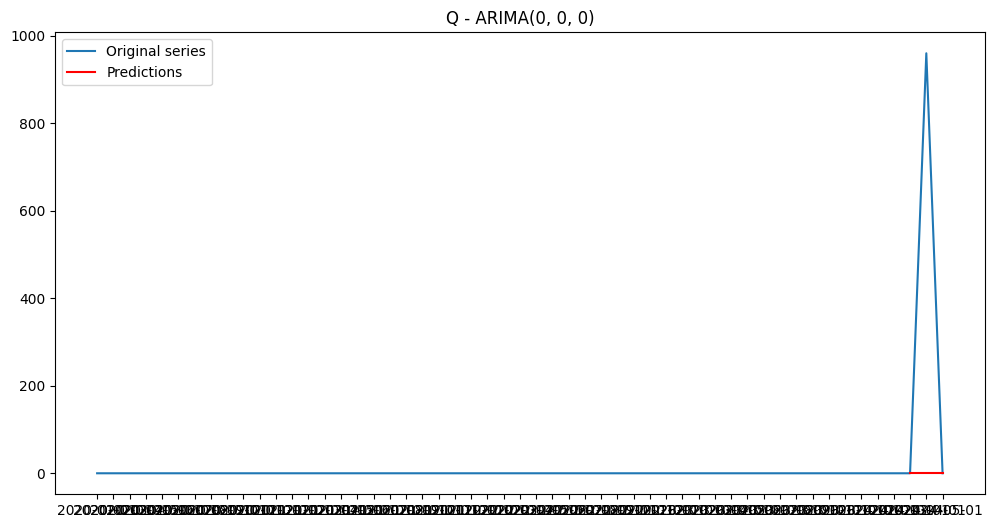

In [14]:
# Parcourir chaque modèle ajusté
for col, model in best_models.items():

    # Diviser les données
    train = dfOrig[col].iloc[:-n]
    test = dfOrig[col].iloc[-n:]

    # Réajuster le modèle sur l'ensemble d'entraînement
    model.fit(train)
    
    # Faire des prévisions sur l'ensemble de test
    predictions = model.predict(n_periods=n)
    
    # Créer une figure pour chaque série
    plt.figure(figsize=(12, 6))
    
    # Tracer la série originale
    plt.plot(dfOrig.index, dfOrig[col], label='Original series')
    
    # Tracer les prévisions
    prediction_index = dfOrig.index[-n:]
    plt.plot(prediction_index, predictions, label='Predictions', color='red')
    
    plt.title(f'{col} - ARIMA{model.order}')
    # Ajouter une légende
    plt.legend()
    
    # Afficher le graphique
    plt.show()
